## Evaluation Density Sampling on Real-World Data (DAMI)

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
sns.set(style="ticks", font_scale=1.25)

In [2]:
from eval_utils import *

In [3]:
OUR_METHOD_NAME = 'RAPID'

In [4]:
pd.options.display.max_columns = None
pd.options.display.precision = 4
pd.options.display.max_rows = 100
nan = np.nan
PLOT_PATH = '../plots'

In [5]:
df = load_results(['dami', 'dami_large', 'dami_baseline_rand', 'dami_baseline_prefiltering', 'dami_baseline_gt', 'dami_outperc', 'dami_large_outperc'])

Data set stats

In [6]:
d = df.groupby(['data_set_name']).mean()[['n_observations', 'outlier_ratio']]
d.describe()

,n_observations,outlier_ratio
count,23.0000,23.0000
mean,6139.2609,0.1790
std,13722.0068,0.1964
min,80.0000,0.0020
25%,246.5000,0.0355
50%,768.0000,0.0912
75%,4513.0000,0.2932
max,49534.0000,0.7538


Inspect exit codes

In [7]:
df.groupby(['sst', 'exit_code']).count()[['ss']]

ss
sst         exit_code                    
BPS         TooLargeSampleException     4
            success                    42
DAEDS       success                    46
DBSRSVDD    success                    46
FBPE        success                    46
HDS         TooLargeSampleException     2
            success                    21
HSR         success                    46
IESRSVDD    success                    46
KFNCBD      success                    46
NDPSR       success                    46
PP_BPS      TooLargeSampleException     6
            success                    63
PP_DAEDS    success                    69
PP_DBSRSVDD EmptySampleException        1
            success                    68
PP_FBPE     success                    69
PP_HSR      success                    69
PP_IESRSVDD success                    69
PP_KFNCBD   success                    69
PP_NDPSR    success                    69
RAPID       success                    69
Rand        TooLargeSampleException   162
            success                  2621

In [8]:
df.query('sst not in ["Rand", "HDS"] and exit_code == "TooLargeSampleException"')[['data_set_name', 'sst', 'sample_size', 'sample_ratio']]

,data_set_name,sst,sample_size,sample_ratio
hash,,,,
7807887620518377250,KDDCup99,PP_BPS,44584,0.9267
16786127536278897661,KDDCup99,BPS,44691,0.9289
12582223330709401559,ALOI,PP_BPS,46107,0.9308
9789069594620330438,ALOI,BPS,46835,0.9455
15033968469500757628,ALOI,PP_BPS,45512,0.9188
6408555107922237821,ALOI,BPS,46835,0.9455
6306833699798069570,ALOI,PP_BPS,37035,0.7477
11914359970203683899,KDDCup99,PP_BPS,43339,0.9008
1674522113091839450,KDDCup99,BPS,44691,0.9289


BPS returned very large samples for ALOI and KDDCup99. In this case SVDD training runtimes become prohibitively long.

In [9]:
df['ss_threshold_strat'] = ['None' if x is np.nan or (type(x) == float and math.isnan(x)) else x for x in df['ss_threshold_strat']]

In [10]:
df_success = df.query('exit_code == "success"').sort_values('ss')

## Our method RAPID against competitors

Comparison values:

**Full:** SVDD fitted on the full data set. Note that parameter tuning is difficult. <br>
**Prefilter:** SVDD fitted on the data set after *pre-filtering*. We can then set C=1 and only have to tune $gamma$.

In [11]:
target_threshold_strat = 'OutPerc(nothing)'

competitors_sst = ['PP_BPS', 'PP_DAEDS', 'PP_DBSRSVDD', 'PP_FBPE', 'PP_HSR', 'PP_IESRSVDD', 'PP_KFNCBD', 'PP_NDPSR']
our_methods = [f'RAPID({target_threshold_strat})']

target_df = df.query('(sst in @competitors_sst or ss in @our_methods)').copy()

target_svdd_result = 'svdd_reinit_ROT_C1_mcc'
target_svdd_result_baseline = 'svdd_reinit_ROT_CTax_mcc'
target_svdd_result_ours = 'svdd_reinit_ROT_C1_mcc'
target_df['t_pred_1k'] = target_df[target_svdd_result.replace('mcc', 'time_pred')] / target_df['n_observations'] * 1000
mask = target_df.query('ss in @our_methods').index

In [12]:
d = target_df.groupby(['data_set_name']).mean()[['n_observations', 'outlier_ratio']]
d.columns = pd.MultiIndex.from_tuples([('stats', 'size'), ('stats', 'out_p')])

for s in competitors_sst:
    x = target_df.query('sst == @s and ss_threshold_strat in [@nan, @target_threshold_strat, "None"]').groupby('data_set_name').mean()[['sample_ratio', target_svdd_result, 'pwc_mcc']]
    x.columns = ['ratio', 'svdd', 'pwc']
    x.columns = pd.MultiIndex.from_tuples([(s, c) for c in x.columns])
    d = pd.merge(d, x, left_index=True, right_index=True, how='outer')
for s in our_methods:
    x = target_df.query('ss == @s').groupby('data_set_name').mean()[['sample_ratio', target_svdd_result_ours, 'pwc_mcc']]
    x.columns = ['ratio', 'svdd', 'pwc']
    short_name = s.split('(')[0] if not 'new' in s else f"{s.split('(')[0]}_new"
    x.columns = pd.MultiIndex.from_tuples([(short_name, c) for c in x.columns])
    d = pd.merge(d, x, left_index=True, right_index=True, how='outer')

for s in ['Rand(1.0)']:
    x = df_success.query('scenario == "dami_baseline_gt"').groupby('data_set_name').mean()[['sample_ratio', 'svdd_mcc', 'pwc_mcc']]
    x.columns = ['ratio', 'svdd', 'pwc']
    short_name = 'Full'
    x.columns = pd.MultiIndex.from_tuples([(short_name, c) for c in x.columns])
    d = pd.merge(d, x, left_index=True, right_index=True, how='outer')

for s in ['Rand(1.0)']:
    x = df_success.query('scenario == "dami_baseline_prefiltering"').groupby('data_set_name').mean()[['sample_ratio', 'svdd_mcc', 'pwc_mcc']]
    x.columns = ['ratio', 'svdd', 'pwc']
    short_name = 'Prefilt'
    x.columns = pd.MultiIndex.from_tuples([(short_name, c) for c in x.columns])
    d = pd.merge(d, x, left_index=True, right_index=True, how='outer')

d = d.round(4)
d

stats          PP_BPS                 PP_DAEDS          \
                     size   out_p   ratio    svdd     pwc    ratio    svdd   
data_set_name                                                                
ALOI              49534.0  0.0304  0.9308     NaN     NaN   0.1841  0.0363   
Annthyroid         7129.0  0.0749  0.7789 -0.0340 -0.0332   0.1763 -0.0377   
Arrhythmia          450.0  0.4578  0.5422  0.3644  0.3580   0.1067  0.2938   
Cardiotocography   2114.0  0.2204  0.6410  0.3696  0.3841   0.1447  0.3717   
Glass               214.0  0.0421  0.4206  0.0721  0.0639   0.1822  0.1249   
HeartDisease        270.0  0.4444  0.5481  0.1900  0.1847   0.1074  0.2348   
Hepatitis            80.0  0.1625  0.8375 -0.0103  0.0647   0.1500 -0.1734   
InternetAds        1966.0  0.1872  0.8128  0.1441  0.1467   0.1495 -0.2575   
Ionosphere          351.0  0.3590  0.4359  0.4676  0.4322   0.1140  0.3768   
KDDCup99          48113.0  0.0042  0.9267     NaN     NaN   0.1890  0.3291   
Lymphography        148.0  0.0405  0.2703  0.6526  0.5998   0.1892  0.2993   
PageBlocks         5393.0  0.0946  0.5555  0.4403  0.3969   0.1706  0.4391   
Parkinson           195.0  0.7538  0.2462 -0.0502 -0.0305   0.0410 -0.1416   
PenDigits          9868.0  0.0020  0.6884  0.0183  0.0145   0.1901 -0.0528   
Pima                768.0  0.3490  0.5013  0.2664  0.2550   0.1276  0.2602   
Shuttle            1013.0  0.0128  0.5094 -0.0125 -0.0135   0.1866 -0.0225   
SpamBase           4207.0  0.3991  0.5981  0.0515  0.0510   0.1148  0.0552   
Stamps              340.0  0.0912  0.4029  0.2977  0.2828   0.1676  0.3634   
WBC                 223.0  0.0448  0.6816  0.7906  0.7511   0.1794  0.7906   
WDBC                367.0  0.0272  0.8910  0.5888  0.5595   0.1744  0.5595   
WPBC                198.0  0.2374  0.7475 -0.0602 -0.0412   0.1414 -0.0303   
Waveform           3443.0  0.0290  0.9707  0.0442  0.0417   0.1836  0.0365   
Wilt               4819.0  0.0533  0.2069 -0.0481 -0.0468   0.1799 -0.0485   

                         PP_DBSRSVDD                 PP_FBPE                  \
                     pwc       ratio    svdd     pwc   ratio    svdd     pwc   
data_set_name                                                                  
ALOI              0.0362      0.0088  0.0330  0.0388  0.0008  0.0349  0.0382   
Annthyroid       -0.0342      0.0018  0.0504 -0.0019  0.0063 -0.0122 -0.0327   
Arrhythmia        0.3471      0.4933  0.3644  0.3601  0.0711  0.2919  0.3260   
Cardiotocography  0.3087      0.0123  0.4083  0.4384  0.0227  0.3430  0.2166   
Glass             0.0567      0.1308 -0.0226  0.1217  0.2103  0.0442  0.0814   
HeartDisease      0.3320      0.0037 -0.0682  0.0000  0.1407  0.0626 -0.0104   
Hepatitis         0.0436      0.6250 -0.1711  0.0488  0.4125 -0.2827 -0.1101   
InternetAds      -0.1244      0.3220 -0.1089 -0.0744  0.0122 -0.1960 -0.1903   
Ionosphere        0.3996      0.1111  0.3048  0.3659  0.0940  0.4838  0.6461   
KDDCup99          0.4257      0.0048  0.1692  0.2474  0.0009  0.0527  0.4302   
Lymphography      0.2901      0.0135  0.0278  0.0000  0.1757  0.6526  0.5304   
PageBlocks        0.4250      0.0032  0.4292  0.4080  0.0087  0.4645  0.2823   
Parkinson        -0.0421      0.2462 -0.0502 -0.0305  0.1282 -0.0677 -0.0554   
PenDigits        -0.0546      0.0004  0.0009  0.0000  0.0045 -0.1661 -0.1744   
Pima              0.2761      0.0690  0.1826  0.1057  0.0586  0.2724  0.2067   
Shuttle          -0.0158      0.0039 -0.0606 -0.0473  0.0365 -0.0181 -0.0119   
SpamBase          0.0282      0.2446  0.0500  0.0212  0.0074  0.0731  0.0700   
Stamps            0.3178      0.0471  0.2338  0.1919  0.1324  0.3372  0.2239   
WBC               0.6859      0.1794  0.7906  0.7263  0.1525  0.7906  0.6859   
WDBC              0.5595      0.2452  0.5595  0.5595  0.1090  0.3302  0.5595   
WPBC             -0.0632      0.4899 -0.0724 -0.0760  0.1717 -0.0780 -0.0572   
Waveform          0.0313      0.1086  0.0333  0.0221  0.0139  0.0722 -0

### Model quality

In [13]:
mcc_mask = d.columns.get_level_values(1) == 'svdd'
d_highlight = d.iloc[:, mcc_mask].copy()
ranks = d_highlight.rank(axis=1, method='min', ascending=False, na_option='bottom')
d_highlight.loc['MEDIAN'] = d_highlight.median(skipna=False)
d_highlight.loc['AVG RANK'] = ranks.median()
d_highlight.style.apply(highlight_max, axis=1)

,PP_BPS,PP_DAEDS,PP_DBSRSVDD,PP_FBPE,PP_HSR,PP_IESRSVDD,PP_KFNCBD,PP_NDPSR,RAPID,Full,Prefilt
,svdd,svdd,svdd,svdd,svdd,svdd,svdd,svdd,svdd,svdd,svdd
data_set_name,,,,,,,,,,,
ALOI,nan,0.0363,0.0330,0.0349,0.0228,0.0365,0.0365,0.0312,0.0364,nan,nan
Annthyroid,-0.0340,-0.0377,0.0504,-0.0122,-0.0356,-0.0342,-0.0342,-0.0383,-0.0300,-0.0048,-0.0304
Arrhythmia,0.3644,0.2938,0.3644,0.2919,-0.0514,0.3644,0.2762,0.3644,0.3308,0.0000,0.3644
Cardiotocography,0.3696,0.3717,0.4083,0.3430,0.3755,0.3696,0.3673,0.3561,0.3635,0.0976,0.3675
Glass,0.0721,0.1249,-0.0226,0.0442,0.0567,-0.0878,0.0639,0.0776,0.1329,0.1217,0.0337
HeartDisease,0.1900,0.2348,-0.0682,0.0626,0.1900,0.1176,-0.2390,0.2120,0.1972,-0.0130,0.1900
Hepatitis,-0.0103,-0.1734,-0.1711,-0.2827,-0.0103,-0.1195,-0.2652,-0.1088,-0.1312,0.0000,-0.0103
InternetAds,0.1441,-0.2575,-0.1089,-0.1960,-0.0470,0.1441,-0.0977,0.0723,0.0635,0.0000,0.1441


### Ratio

In [14]:
mcc_mask = d.columns.get_level_values(1) == 'ratio'
d_highlight = d.iloc[:, mcc_mask].copy()
ranks = d_highlight.rank(axis=1, method='min', ascending=True, na_option='bottom')
d_highlight.loc['MEAN'] = d_highlight.mean()
d_highlight.loc['AVG RANK'] = ranks.mean()
d_highlight.style.apply(highlight_min, axis=1)

,PP_BPS,PP_DAEDS,PP_DBSRSVDD,PP_FBPE,PP_HSR,PP_IESRSVDD,PP_KFNCBD,PP_NDPSR,RAPID,Full,Prefilt
,ratio,ratio,ratio,ratio,ratio,ratio,ratio,ratio,ratio,ratio,ratio
data_set_name,,,,,,,,,,,
ALOI,0.9308,0.1841,0.0088,0.0008,0.0008,0.0781,0.1939,0.0210,0.0004,nan,nan
Annthyroid,0.7789,0.1763,0.0018,0.0063,0.0161,0.3765,0.1850,0.0112,0.0070,1.0000,0.9251
Arrhythmia,0.5422,0.1067,0.4933,0.0711,0.0022,0.3756,0.1067,0.4733,0.1156,1.0000,0.5422
Cardiotocography,0.6410,0.1447,0.0123,0.0227,0.3623,0.3723,0.1556,0.0856,0.0128,1.0000,0.7796
Glass,0.4206,0.1822,0.1308,0.2103,0.4299,0.2009,0.1916,0.1963,0.0280,1.0000,0.9579
HeartDisease,0.5481,0.1074,0.0037,0.1407,0.5519,0.2963,0.1111,0.0259,0.0778,1.0000,0.5556
Hepatitis,0.8375,0.1500,0.6250,0.4125,0.8250,0.6375,0.1625,0.6500,0.4625,1.0000,0.8375
InternetAds,0.8128,0.1495,0.3220,0.0122,0.0005,0.7696,0.1623,0.6607,0.4908,1.0000,0.8128


### Additional stats for top methods

In [15]:
d_ext = []
for s in competitors_sst:
    t_col = ['time_sampling', f'{target_svdd_result[:-4]}_time_train', f'{target_svdd_result[:-4]}_time_pred', 'sample_size', 'sample_ratio', f'{target_svdd_result[:-4]}_num_support_vectors', target_svdd_result, 'pwc_mcc']
    x = target_df.query('sst == @s and ss_threshold_strat in [@nan, @target_threshold_strat, "None"]').groupby('data_set_name').mean()[t_col]
    x.columns = ['t_samp', 't_train', 't_pred', 'size', 'ratio', 'SVs', 'svdd', 'pwc']
    x['ss'] = s
    d_ext.append(x[['ss', 't_samp', 't_train', 't_pred', 'size', 'ratio', 'SVs', 'svdd', 'pwc']])
for s in our_methods:
    t_col = ['time_sampling', f'{target_svdd_result_ours[:-4]}_time_train', f'{target_svdd_result_ours[:-4]}_time_pred', 'sample_size', 'sample_ratio', f'{target_svdd_result_ours[:-4]}_num_support_vectors', target_svdd_result_ours, 'pwc_mcc']
    x = target_df.query('ss == @s').groupby('data_set_name').mean()[t_col]
    x.columns = ['t_samp', 't_train', 't_pred', 'size', 'ratio', 'SVs', 'svdd', 'pwc']
    x['ss'] = s.split('(')[0] if not 'new' in s else f"{s.split('(')[0]}_new"
    d_ext.append(x[['ss', 't_samp', 't_train', 't_pred', 'size', 'ratio', 'SVs', 'svdd', 'pwc']])
d_ext = pd.concat(d_ext).reset_index()

In [16]:
d_ext = []
for s in competitors_sst:
    t_col = ['time_sampling', f'{target_svdd_result[:-4]}_time_train', 't_pred_1k', 'sample_size', 'sample_ratio', f'{target_svdd_result[:-4]}_num_support_vectors', target_svdd_result, 'pwc_mcc']
    x = target_df.query('sst == @s and ss_threshold_strat in [@nan, @target_threshold_strat, "None"]').groupby('data_set_name').mean()[t_col]
    x.columns = ['t_samp', 't_train', 't_pred', 'size', 'ratio', 'SVs', 'svdd', 'pwc']
    x['ss'] = s
    d_ext.append(x[['ss', 't_samp', 't_train', 't_pred', 'size', 'ratio', 'SVs', 'svdd', 'pwc']])
for s in our_methods:
    t_col = ['time_sampling', f'{target_svdd_result_ours[:-4]}_time_train', 't_pred_1k', 'sample_size', 'sample_ratio', f'{target_svdd_result_ours[:-4]}_num_support_vectors', target_svdd_result_ours, 'pwc_mcc']
    x = target_df.query('ss == @s').groupby('data_set_name').mean()[t_col]
    x.columns = ['t_samp', 't_train', 't_pred', 'size', 'ratio', 'SVs', 'svdd', 'pwc']
    x['ss'] = s.split('(')[0] if not 'new' in s else f"{s.split('(')[0]}_new"
    d_ext.append(x[['ss', 't_samp', 't_train', 't_pred', 'size', 'ratio', 'SVs', 'svdd', 'pwc']])
d_ext = pd.concat(d_ext).reset_index()

In [17]:
stats = d_ext
stats = stats.groupby(['ss', 'data_set_name']).mean().reset_index().groupby('ss').median()
stats.insert(3, 't_tot', stats[['t_samp', 't_train', 't_pred']].sum(axis=1))
stats = stats[['t_samp', 't_train', 't_pred', 'size', 'ratio', 'svdd']]
stats.round(2)
#print(stats.round(2).to_latex())

,t_samp,t_train,t_pred,size,ratio,svdd
ss,,,,,,
PP_BPS,0.61,0.47,0.15,385,0.60,0.14
PP_DAEDS,0.59,0.04,0.07,98,0.17,0.12
PP_DBSRSVDD,0.01,0.02,0.01,40,0.07,0.03
PP_FBPE,0.07,0.02,0.01,39,0.06,0.06
PP_HSR,0.47,0.07,0.03,130,0.36,0.04
PP_IESRSVDD,0.02,0.10,0.03,154,0.22,0.12
PP_KFNCBD,0.53,0.06,0.04,100,0.18,0.05
PP_NDPSR,0.51,0.07,0.03,103,0.21,0.08
RAPID,0.02,0.02,0.01,21,0.03,0.13


In [18]:
d_ext.groupby(['ss', 'data_set_name']).mean().reset_index().groupby('ss').count()

,data_set_name,t_samp,t_train,t_pred,size,ratio,SVs,svdd,pwc
ss,,,,,,,,,
PP_BPS,23,23,21,21,23,23,21,21,21
PP_DAEDS,23,23,23,23,23,23,23,23,23
PP_DBSRSVDD,23,23,23,23,23,23,23,23,23
PP_FBPE,23,23,23,23,23,23,23,23,23
PP_HSR,23,23,23,23,23,23,23,23,23
PP_IESRSVDD,23,23,23,23,23,23,23,23,23
PP_KFNCBD,23,23,23,23,23,23,23,23,23
PP_NDPSR,23,23,23,23,23,23,23,23,23
RAPID,23,23,23,23,23,23,23,23,23


BPS produced prohibitively large samples (>40k observations) on the ALOI and KDDCup99 data set. The median is therefore missleading and we report it as NaN.

Overview results with **mean** aggregation:

In [19]:
stats = d_ext
stats = stats.groupby(['ss', 'data_set_name']).mean().reset_index().groupby('ss').mean()
stats.insert(3, 't_tot', stats[['t_samp', 't_train', 't_pred']].sum(axis=1))
stats = stats[['t_samp', 't_train', 't_pred', 'size', 'ratio', 'svdd']]
stats.round(2)
#print(stats.round(2).to_latex())

,t_samp,t_train,t_pred,size,ratio,svdd
ss,,,,,,
PP_BPS,9.75,113.45,0.68,5143.30,0.61,0.22
PP_DAEDS,31.35,511.07,0.28,1110.04,0.15,0.17
PP_DBSRSVDD,7.25,0.64,0.22,150.13,0.15,0.13
PP_FBPE,3.53,0.02,0.02,38.04,0.09,0.15
PP_HSR,5.83,194.40,0.16,718.91,0.38,0.17
PP_IESRSVDD,20.67,392.14,0.56,1430.35,0.31,0.18
PP_KFNCBD,36.99,641.71,0.33,1169.74,0.16,0.16
PP_NDPSR,13.93,3.07,0.33,302.30,0.24,0.20
RAPID,5.60,182.10,0.33,491.52,0.11,0.20


RAPID mean values for t_samp, t_train, size and ratio are higher because RAPID returns a very large sample for only one data set (PenDigits).

### Comparison against full data set

In [20]:
d_prefit = df_success.query('scenario == "dami_baseline_prefiltering"')

In [21]:
d_prefit[['sample_size', 'svdd_time_train']].describe()

,sample_size,svdd_time_train
count,21.0000,21.0000
mean,1839.3810,470.9339
std,2635.1314,1258.0780
min,48.0000,0.0357
25%,205.0000,0.1781
50%,357.0000,0.6591
75%,2528.0000,166.3355
max,9859.0000,5140.2753


Quality deviation of RAPID compared to SVDD trained after the pre-filtering.

In [22]:
(d[[('RAPID', 'svdd')]].values - d[[('Prefilt', 'svdd')]]).describe()

,Prefilt
,svdd
count,21.0000
mean,0.0019
std,0.0674
min,-0.1209
25%,-0.0336
50%,0.0000
75%,0.0091
max,0.1884


---

### Plot

In [23]:
target_threshold_strat = 'OutPerc(nothing)'

competitors_sst = ['BPS', 'DAEDS', 'DBSRSVDD', 'FBPE', 'HSR', 'IESRSVDD', 'KFNCBD', 'NDPSR']
competitors_sst_pp = ['PP_BPS', 'PP_DAEDS', 'PP_DBSRSVDD', 'PP_FBPE', 'PP_HSR', 'PP_IESRSVDD', 'PP_KFNCBD', 'PP_NDPSR']
our_methods = [f'RAPID({target_threshold_strat})']

target_df = df_success.query('(sst in @competitors_sst or sst in @competitors_sst_pp or ss in @our_methods)').copy()

target_svdd_result = 'svdd_reinit_ROT_CTax_mcc'
target_svdd_result_pp = 'svdd_reinit_ROT_C1_mcc'
target_svdd_result_baseline = 'svdd_reinit_ROT_CTax_mcc'
target_svdd_result_ours = 'svdd_reinit_ROT_C1_mcc'

In [24]:
d_plot = []
for s in competitors_sst:
    x = target_df.query('sst == @s and ss_threshold_strat in ["None", @target_threshold_strat]').groupby(['sst', 'ss', 'data_set_name']).median()[['sample_ratio', target_svdd_result, 'pwc_mcc']].reset_index()
    x.columns = ['sst', 'ss', 'data', 'ratio', 'svdd', 'pwc']
    d_plot.append(x)
    
for s in competitors_sst_pp:
    x = target_df.query('sst == @s and ss_threshold_strat in ["None", @target_threshold_strat]').groupby(['sst', 'ss', 'data_set_name']).median()[['sample_ratio', target_svdd_result_pp, 'pwc_mcc']].reset_index()
    x.columns = ['sst', 'ss', 'data', 'ratio', 'svdd', 'pwc']
    d_plot.append(x)

for s in ['Rand']:
    x = df_success.query('sst == @s and ss_threshold_strat in ["None", @target_threshold_strat]').groupby(['sst', 'ss', 'data_set_name']).median()[['sample_ratio', target_svdd_result_baseline, 'pwc_mcc']].reset_index()
    x.columns = ['sst', 'ss', 'data', 'ratio', 'svdd', 'pwc']
    d_plot.append(x)

for s in our_methods:
    x = target_df.query('ss == @s').groupby(['sst', 'ss', 'data_set_name']).median()[['sample_ratio', target_svdd_result_ours, 'pwc_mcc']].reset_index()
    x.columns = ['sst', 'ss', 'data', 'ratio', 'svdd', 'pwc']
    d_plot.append(x)

d_plot = pd.concat(d_plot).set_index('data')
d_plot['removed'] = 1 - d_plot['ratio']
d_plot.reset_index(inplace=True)

In [25]:
markers = {}
filled_markers = ('o', 'v', 'p', 'D', 'P', 'X', '^', '<', '*', '>')
for i, s in enumerate(competitors_sst):
    markers[s] = filled_markers[i]
markers['RAPID'] = 's'

### Avg over all data sets

In [26]:
colorpalette = sns.cubehelix_palette(8, start=2.666, rot=-.01, light=0.7) + [(0.8545371341681446, 0.22957019267094914, 0.2762321841840895)]

In [27]:
sns.set(style="ticks", font_scale=1.0, rc={'figure.figsize':(6, 3.5)})
d_plot_all = d_plot.query('sst not in ["HDS", "Rand", "PP_BPS"]').groupby(['sst']).median().reset_index()
d_plot_all.sst = d_plot_all.sst.str.replace('PP_', '')
f = sns.scatterplot(data=d_plot_all, x='removed', y='svdd', hue='sst', style='sst', hue_order=[x for x in markers.keys() if x in d_plot_all.sst.values], markers=markers, s=50, edgecolor=None, palette=colorpalette)
x = d_plot.query('(removed <= 0.90) and sst == "Rand"').groupby('ss').median()
plt.scatter(x['removed'], x['svdd'], color='grey', alpha=1, label="Rand", s=10)

handles, labels = f.axes.get_legend_handles_labels()
plt.legend(handles=[handles[-2]] + handles[1:-2] + [handles[-1]], labels=[OUR_METHOD_NAME] + labels[1:-2] + [labels[-1]], bbox_to_anchor=(1.05, 1), loc=0, title=None)
eps_x, eps_y = 0.05, 0.01
top_left_box_p = d_plot_all.query('sst == "BPS"').min()
bot_right_box_p_x = d_plot_all.query('sst == "FBPE" and removed > 0.9')
bot_right_box_p_y = d_plot_all.query('sst == "DBSRSVDD" and removed < 0.91')
box_x_min, box_x_max = top_left_box_p.removed  - eps_x, bot_right_box_p_x.removed.values[0]  + eps_x
box_y_min, box_y_max = bot_right_box_p_y.svdd.values[0]  - eps_y, top_left_box_p.svdd  + eps_y
r = Rectangle((box_x_min, box_y_min), box_x_max - box_x_min, box_y_max - box_y_min,
              fill=False, linestyle='dashed', color='black')
f.axes.add_patch(r)
plt.text((box_x_max - box_x_min) * 0.25, -0.03, 'no pre-filtering')
plt.tight_layout()
plt.ylim(-0.06, 0.16)
plt.yticks([-0.05, 0.0, 0.05, 0.1, 0.15])
plt.xlabel('1 - sample ratio')
plt.ylabel('SVDD MCC')
plt.savefig(os.path.join(PLOT_PATH, f"eval_avg.pdf"))
plt.savefig(os.path.join(PLOT_PATH, f"eval_avg.png"), dpi=300)

### Results per data set

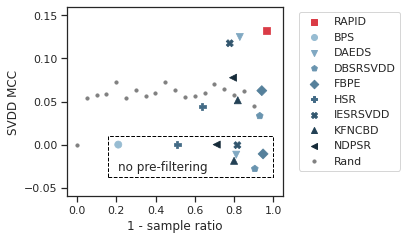

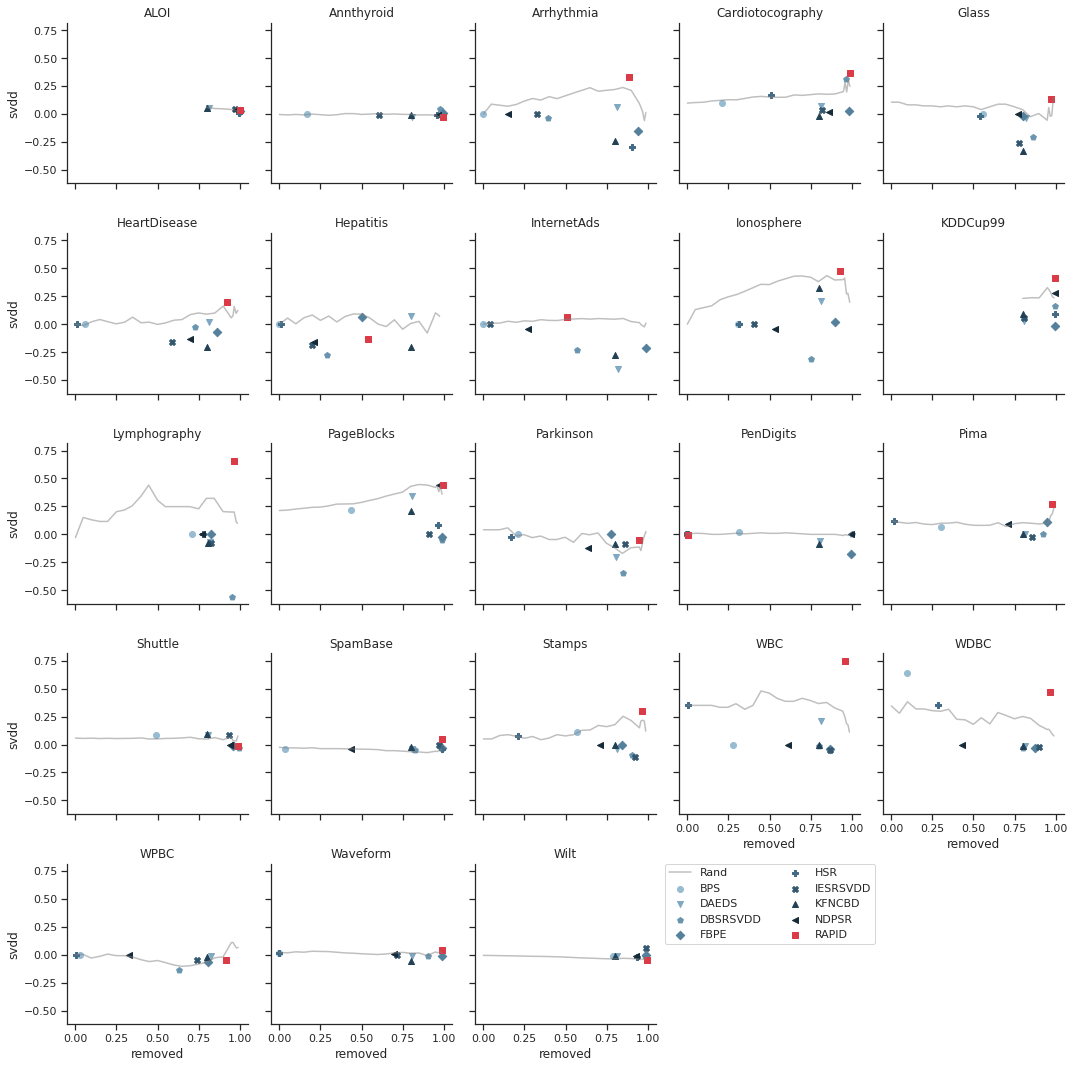

In [28]:
f = sns.FacetGrid(d_plot.query('sst not in ["Rand", "HDS"]'), col='data', col_wrap=5, col_order=sorted(d_plot.data.unique()), hue='sst', hue_order=markers.keys(), hue_kws=dict(marker=list(markers.values())), legend_out=False, palette=colorpalette)
for idx, data_name in enumerate(sorted(f.col_names)):
    x = d_plot.query('sst == "Rand" and data == @data_name')
    f.axes[idx].plot(x['removed'], x['svdd'], color='grey', alpha=0.5, label="Rand")
f.map(plt.scatter, "removed", 'svdd')
f.set_titles('{col_name}')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=2)

## Other outlier percentages for pre-filtering

We vary the outlier percentage by underestimating (5%) and overestimating (25%) it.

In [29]:
def avg_plot(target_threshold_strat):
    competitors_sst = ['BPS', 'DAEDS', 'DBSRSVDD', 'FBPE', 'HSR', 'IESRSVDD', 'KFNCBD', 'NDPSR']
    competitors_sst_pp = ['PP_BPS', 'PP_DAEDS', 'PP_DBSRSVDD', 'PP_FBPE', 'PP_HSR', 'PP_IESRSVDD', 'PP_KFNCBD', 'PP_NDPSR']
    our_methods = [f'RAPID({target_threshold_strat})']

    target_df = df_success.query('(sst in @competitors_sst or sst in @competitors_sst_pp or ss in @our_methods)').copy()

    d_plot = []
    for s in competitors_sst:
        x = target_df.query('sst == @s and ss_threshold_strat in ["None", @target_threshold_strat]').groupby(['sst', 'ss', 'data_set_name']).median()[['sample_ratio', target_svdd_result, 'pwc_mcc']].reset_index()
        x.columns = ['sst', 'ss', 'data', 'ratio', 'svdd', 'pwc']
        d_plot.append(x)

    for s in competitors_sst_pp:
        x = target_df.query('sst == @s and ss_threshold_strat in ["None", @target_threshold_strat]').groupby(['sst', 'ss', 'data_set_name']).median()[['sample_ratio', target_svdd_result_pp, 'pwc_mcc']].reset_index()
        x.columns = ['sst', 'ss', 'data', 'ratio', 'svdd', 'pwc']
        d_plot.append(x)

    for s in ['Rand']:
        x = df_success.query('sst == @s and ss_threshold_strat in ["None", @target_threshold_strat]').groupby(['sst', 'ss', 'data_set_name']).median()[['sample_ratio', target_svdd_result_baseline, 'pwc_mcc']].reset_index()
        x.columns = ['sst', 'ss', 'data', 'ratio', 'svdd', 'pwc']
        d_plot.append(x)

    for s in our_methods:
        x = target_df.query('ss == @s').groupby(['sst', 'ss', 'data_set_name']).median()[['sample_ratio', target_svdd_result_ours, 'pwc_mcc']].reset_index()
        x.columns = ['sst', 'ss', 'data', 'ratio', 'svdd', 'pwc']
        d_plot.append(x)

    d_plot = pd.concat(d_plot).set_index('data')
    d_plot['removed'] = 1 - d_plot['ratio']
    d_plot.reset_index(inplace=True)
    
    sns.set(style="ticks", font_scale=1.0, rc={'figure.figsize':(6, 3.5)})
    d_plot_all = d_plot.query('sst not in ["HDS", "Rand", "PP_BPS"]').groupby(['sst']).median().reset_index()
    d_plot_all.sst = d_plot_all.sst.str.replace('PP_', '')
    f = sns.scatterplot(data=d_plot_all, x='removed', y='svdd', hue='sst', style='sst', hue_order=[x for x in markers.keys() if x in d_plot_all.sst.values], markers=markers, s=50, edgecolor=None, palette=colorpalette)
    x = d_plot.query('(removed <= 0.90) and sst == "Rand"').groupby('ss').median()
    plt.scatter(x['removed'], x['svdd'], color='grey', alpha=1, label="Rand", s=10)

    handles, labels = f.axes.get_legend_handles_labels()
    plt.legend(handles=[handles[-2]] + handles[1:-2] + [handles[-1]], labels=[OUR_METHOD_NAME] + labels[1:-2] + [labels[-1]], bbox_to_anchor=(1.05, 1), loc=0, title=None)
    eps_x, eps_y = 0.05, 0.01
    top_left_box_p = d_plot_all.query('sst == "BPS"').min()
    bot_right_box_p_x = d_plot_all.query('sst == "FBPE" and removed > 0.9')
    bot_right_box_p_y = d_plot_all.query('sst == "DBSRSVDD" and removed < 0.91')
    box_x_min, box_x_max = top_left_box_p.removed  - eps_x, bot_right_box_p_x.removed.values[0]  + eps_x
    box_y_min, box_y_max = bot_right_box_p_y.svdd.values[0]  - eps_y, top_left_box_p.svdd  + eps_y
    r = Rectangle((box_x_min, box_y_min), box_x_max - box_x_min, box_y_max - box_y_min,
                  fill=False, linestyle='dashed', color='black')
    f.axes.add_patch(r)
    plt.text((box_x_max - box_x_min) * 0.25, -0.03, 'no pre-filtering')
    plt.tight_layout()
    plt.ylim(-0.06, 0.16)
    plt.yticks([-0.05, 0.0, 0.05, 0.1, 0.15])
    plt.xlabel('1 - sample ratio')
    plt.ylabel('SVDD MCC')
    return f

Underestimation

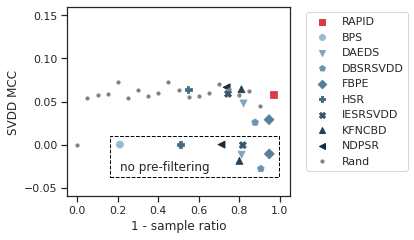

In [30]:
avg_plot('OutPerc(0.05)')

Overestimation

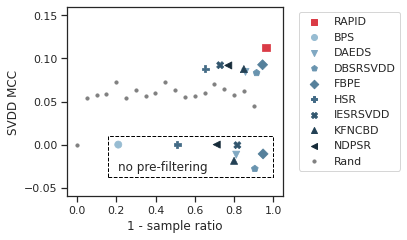

In [31]:
avg_plot('OutPerc(0.25)')